In [1]:
import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import os
dict_num={'arashi':0,'sexy':8,'Twice':8,'west':0,'oneok':0}
#class label name
dirname=['arashi','sexy','Twice','west','oneok']
"""n_mels:メル周波数
   n_fft:フーリエ変換周波数
   hop_length:連続フレーム周波数
   load_dataに水増しを加える
   答えの一致をみるために楽曲ファイルを画像変換する関数も作る
   class化"""
#test
dirname=['arashi','sexy','Twice','west']
n_mels=128
n_fft=2048
hop_length=2068
def load_data(training_rate,repeat_num):
    images=[]
    labels=[]
    for i in range(len(dirname)):
        #pathのリストを獲得
        file_list=glob.glob('{}/*.wav'.format(dirname[i]))
        for fname in file_list:
            for k in range(repeat_num):
                y,sr=librosa.load(fname,sr=4410,offset=0.0,duration=60.0)
                #パワースペクトル
                S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=n_mels,hop_length=hop_length,n_fft=n_fft)
                #音圧スペクトルにする
                log_S=librosa.power_to_db(S,ref=np.max)
                #音圧スペクトルを画像と見立てる
                img=log_S
                img=cv2.resize(img,(96,96))
                images.append(img)
                labels.append(i)
            
    #index random
    idx=np.arange(len(labels))
    np.random.shuffle(idx)
    images_new=[]
    labels_new=[]
    for iidx in idx:
        images_new.append(images[iidx])
        labels_new.append(labels[iidx])
    n_samples=len(labels_new)
    training_num=int(n_samples*training_rate)
    return images_new[:training_num],labels_new[:training_num],images_new[training_num:],labels_new[training_num:]

def onehot(labels,num_classes):
    label_onehot=[]
    for k in range(len(labels)):
        onehot=np.zeros(num_classes)
        for j in range(num_classes):
            if labels[k]==j:
                onehot[j]=1
        label_onehot.append(list(onehot))
        
    return label_onehot
 
#一つずつ画像化
def load_data_one(dirname,repeat_num,class_num):
    mus_list=glob.glob('{}/*.wav'.format(dirname))
    img_list=[]
    labels=[]
    for fname in mus_list:
        for k in range(repeat_num):
            y,sr=librosa.load(fname,sr=4410,offset=10.0*k,duration=60.0)
            S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=n_mels,hop_length=hop_length,n_fft=n_fft)
            logS=librosa.power_to_db(S,ref=np.max)
            img=logS
            img=cv2.resize(img,(96,96))
            img_list.append(img)
            labels.append(class_num)
            
    return img_list,labels


In [2]:
X_train,y_train,X_test,y_test=load_data(training_rate=0.8,repeat_num=8)
X_train=np.array(X_train)
X_test=np.array(X_test)
X_train=X_train.reshape(-1,96,96,1)/255
X_test=X_test.reshape(-1,96,96,1)/255

num_classes=len(dirname)
y_train=onehot(y_train,num_classes)
y_test=onehot(y_test,num_classes)
y_train=np.array(y_train)
y_test=np.array(y_test)

print('==shape==')
print('==train==')
print(X_train.shape)
print(y_train.shape)
print('==test==')
print(X_test.shape)
print(y_test.shape)

==shape==
==train==
(1811, 96, 96, 1)
(1811, 4)
==test==
(453, 96, 96, 1)
(453, 4)


Epoch 1/50
1811/1811 [==============================] - 22s 12ms/step - loss: 4.1341 - acc: 0.3335
Epoch 2/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.3049 - acc: 0.5163
Epoch 3/50
1811/1811 [==============================] - 23s 12ms/step - loss: 1.2757 - acc: 0.5257
Epoch 4/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.2127 - acc: 0.5279
Epoch 5/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.2297 - acc: 0.5279
Epoch 6/50
1811/1811 [==============================] - 23s 13ms/step - loss: 1.7830 - acc: 0.3821
Epoch 7/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.2809 - acc: 0.1469
Epoch 8/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.2711 - acc: 0.1253
Epoch 9/50
1811/1811 [==============================] - 23s 13ms/step - loss: 1.2268 - acc: 0.1099
Epoch 10/50
1811/1811 [==============================] - 22s 12ms/step - loss: 1.2713 - acc: 0.0817
Epoch 11/

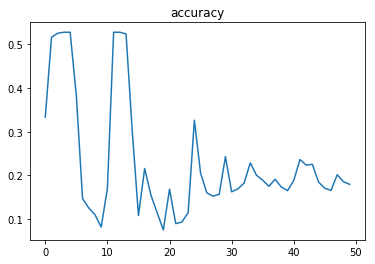

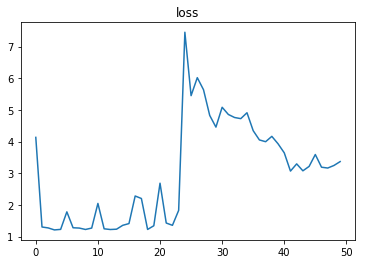

In [5]:
#深層学習モデル簡略化
import keras
from keras.models import Sequential
#Flattenは平坦化
from keras.layers import Dropout,Dense,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

model=Sequential()
model.add(Conv2D(16,kernel_size=(4,4),activation='relu',input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(24,kernel_size=(4,4),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))

model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
#ミニバッチ学習
hist=model.fit(X_train,y_train,batch_size=48,epochs=50,verbose=1)

#モデル評価
score=model.evaluate(X_test,y_test,verbose=1)
print('accuracy:',score[1],'loss:',score[0])

#正解率
plt.figure(figsize=(6,4))
plt.plot(hist.history['acc'])
plt.title('accuracy')
plt.show()

#損失
plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'])
plt.title('loss')
plt.show()

#モデルを保存
model.save('music-2.h5')
model.save_weights('music_weights-2.h5')